# Prediciendo datos del uso compartido de bicicletas

En este proyecto vamos a construir una red neuronal desde cero, y la usaremos para predecir el número de personas que rentan bicicletas.

## Índice
- [Cargando los datos](#load-data)
- [Inspeccionando los datos](#check-data)
- [Preparando los datos](#prepare-data)
  - Codificación One-hot
  - Escalando variables objetivo
  - Dividiendo los datos en conjuntos de entrenamiento, prueba y validación
- [Construyendo la red](#build-network)
  - La clase NeuralNetwork
  - Pruebas unitarias
- [Entrenando la red](#train-network)
  - Número de iteraciones
  - Tasa de aprendizaje
  - Número de nodos ocultos
- [Analizando predicciones](#predictions)

Primero, importemos algunas librerías que usaremos.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Cargando los datos <a id='load-data'></a>

El primer paso cuando trabajamos con redes neuronales es cargar los datos con los que trabajaremos.

In [2]:
data_path = 'bike-sharing-dataset/hour.csv'

rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Inspeccionando los datos <a id='check-data'></a>

Ahora, examinemos los datos (los datos provienen de [UCI Machine Learning Database](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)).

El conjunto de datos contiene el recuento por hora de las rentas de bicicletas desde el 1 de enero de 2011 hasta el 31 de diciembre de 2012, perteneciente al sistema Capital Bikeshare con la información meteorológica y estacional correspondiente. El número de pasajeros se divide entre casual y registrado, sumados en la columna `cnt`. Puedes ver las primeras filas de los datos en la tabla anterior.

A continuación se muestra un gráfico que muestra el número de ciclistas durante los primeros 10 días en el conjunto de datos (algunos días no tienen exactamente 24 entradas en el conjunto de datos, por lo que no son exactamente 10 días).

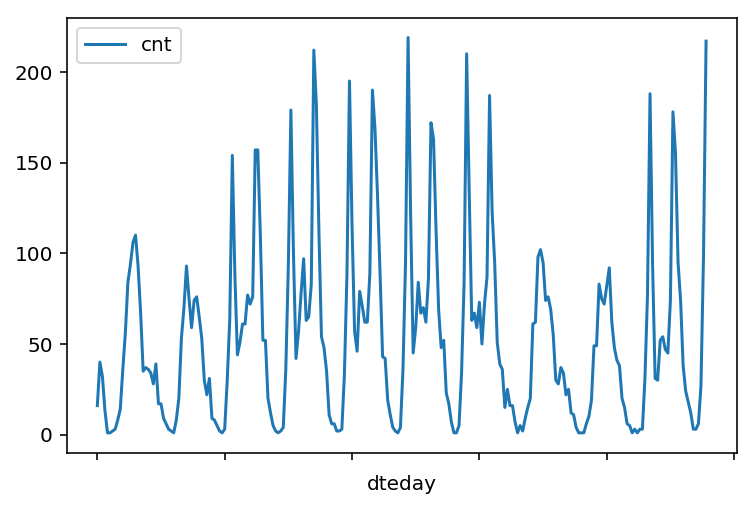

In [3]:
rides[:24*10].plot(x='dteday', y='cnt')

¡Esta información es bastante complicada! Los fines de semana tienen un número de ciclistas más bajo y hay picos cuando las personas van en bicicleta hacia y desde el trabajo durante la semana.

Revisando los datos anteriores, también tenemos información sobre la temperatura, la humedad y la velocidad del viento, lo que probablemente afecte a la cantidad de ciclistas. Trataremos de capturar todo esto con nuestro modelo.

## Preparando los datos <a id='prepare-data'></a>

Un paso importante cuando se trabaja con redes neuronales es preparar los datos correctamente. Las variables en diferentes escalas dificultan que la red aprenda eficientemente los pesos correctos.

### Codificación One-hot

La codificación One-hot es el proceso mediante el cual las variables categóricas se convierten en una forma que podría proporcionarse a los algoritmos de Aprendizaje automático (Machine Learning) para que hagan un mejor trabajo en la predicción. En nuestro caso, tenemos algunas variables categóricas como la estación, el clima y el mes. Para incluir estos en nuestro modelo, necesitaremos hacer variables ficticias binarias (dummy variables).

La codificación One-hot es fácil con la función `get_dummies` en Pandas.

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for field in dummy_fields:
    dummies = pd.get_dummies(rides[field], prefix=field)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 'mnth', 'hr', 'weekday', 'atemp', 'workingday']

data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Escalando variables objetivo

Para facilitar el entrenamiento de la red, estandarizaremos cada una de las variables continuas. Es decir, cambiaremos y escalaremos las variables de modo que tengan una media cero y una desviación estándar de 1.

Los factores de escala se guardarán, de modo que podamos utilizar los valores originales cuando usemos la red para las predicciones.

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']

# Guardar los factores de escala en un diccionario para que podamos usarlas más tarde
scaled_features = {}

for quant in quant_features:
    mean, std = data[quant].mean(), data[quant].std()
    scaled_features[quant] = [mean, std]
    data.loc[:, quant] = (data[quant] - mean) / std

data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,1,0,...,0,0,0,0,0,0,0,0,0,1


### Dividiendo los datos en conjuntos de entrenamiento, prueba y validación

Entrenamos a nuestros modelos con el conjunto de entrenamiento sin mirar el conjunto de prueba, y luego evaluamos los resultados con el conjunto de prueba para ver qué tan bien predice el modelo.

Guardaremos los datos de los últimos 21 días aproximadamente para utilizarlos como un conjunto de prueba una vez que hayamos entrenado la red neuronal. Utilizaremos este conjunto para hacer predicciones y compararlas con el número real de ciclistas.

In [6]:
# Guardar datos de aproximadamente los últimos 21 días
test_data = data[-21*24:]

# Eliminar los datos de prueba del conjunto de datos
data = data[:-21*24]

# Separar los datos en features (X) y targets(y)
target_fields = ['cnt', 'casual', 'registered']

features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

Finalmente, dividiremos los datos de `features` (características) y `targets` (objetivos) en 2 conjuntos, uno para entrenamiento y otro para validación a medida que la red se está entrenando.

In [7]:
# Hold out the last 60 days or so of the remaining data as a validation set
hold = 24 * 60

train_features, train_targets = features[:-hold], targets[:-hold]
val_features, val_targets = features[-hold:], targets[-hold:]

In [8]:
train_features.shape

(15435, 56)

In [9]:
train_features[:5]

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334609,0.947345,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438475,0.895513,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334609,0.636351,-1.553844,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [10]:
val_features.shape

(1440, 56)

In [11]:
val_features[:5]

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
15435,1,0,0.015647,0.740016,-0.211685,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
15436,1,0,0.223378,-0.141133,0.764282,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
15437,1,0,0.327244,-0.555792,0.886073,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
15438,1,0,0.223378,-0.555792,0.031898,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0
15439,1,0,0.223378,-0.348463,0.276298,0,0,0,1,1,...,0,0,0,0,0,0,1,0,0,0


In [12]:
test_features.shape

(504, 56)

In [13]:
test_features[:5]

,yr,holiday,temp,hum,windspeed,season_1,season_2,season_3,season_4,weathersit_1,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
16875,1,0,0.015647,0.999178,0.276298,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0
16876,1,0,-0.192085,1.310171,0.519881,0,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
16877,1,0,-0.192085,0.740016,2.228232,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
16878,1,0,-0.399817,0.429022,2.106440,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
16879,1,0,-0.503683,0.169861,1.130474,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


## Construyendo la red <a id='build-network'></a>

La red tiene 2 capas, una capa oculta (hidden) y una capa de salida (output). La capa oculta usará la función sigmoide para las activaciones. La capa de salida tiene solo un nodo y se usa para la regresión, la salida del nodo es la misma que la entrada del nodo. Es decir, la función de activación es $f(x) = x$.

![Neural Network](img/1.png)

Recuerda que una función que toma la señal de entrada y genera una señal de salida, pero que toma en cuenta un umbral, se llama función de activación. Trabajamos a través de cada capa de nuestra red calculando los resultados para cada neurona. Todas las salidas de una capa se convierten en entradas para las neuronas en la siguiente capa. Este proceso se llama *feedforward*.

Usaremos los pesos para propagar señales hacia adelante desde la entrada a las capas de salida en una red neuronal. También usaremos los pesos para propagar el error desde la salida hacia la red para actualizar nuestros pesos. Esto se llama *backpropagation*.

### La clase NeuralNetwork

Vamos a encapsular toda la lógica relacionada con nuestra red neuronal en la siguiente clase.

In [14]:
class NeuralNetwork:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        # Usar la misma semilla para depurar con facilidad
        np.random.seed(21)
        
        # Guardar el número de nodos en las capas de entrada, oculta y salida
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        # Guardar la tasa de aprendizaje
        self.learning_rate = learning_rate
        
        # Inicializar los pesos
        self.weights_input_to_hidden = np.random.normal(0.0, self.input_nodes ** -0.5,
                                                        (self.input_nodes, self.hidden_nodes))
        self.weights_hidden_to_output = np.random.normal(0.0, self.hidden_nodes ** -0.5,
                                                        (self.hidden_nodes, self.output_nodes))
        
        # Configurar la función de activación
        self.activation_function = lambda x : 1 / (1 + np.exp(-x))
    
    def train(self, features, targets):
        ''' Entrenar la red en lotes de features y targets. 
        
            Argumentos
            ---------
            features: arreglo 2D, cada fila es un registro de los datos, cada columna es una característica (feature)
            targets: arreglo 1D de valores objetivos
        '''
        n_records = features.shape[0]
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        
        for X, y in zip(features, targets):
            hidden_outputs, final_outputs = self.feedforward(X)
            delta_weights_i_h, delta_weights_h_o = self.backpropagation(final_outputs, hidden_outputs, X, y, 
                                                                        delta_weights_i_h, delta_weights_h_o)
        
        self.update_weights(delta_weights_i_h, delta_weights_h_o, n_records)
    
    def feedforward(self, X):
        ''' Feedforward
         
            Argumentos
            ---------
            X: lote de features
        '''
        # Capa oculta
        hidden_inputs = np.dot(X, self.weights_input_to_hidden) # Señales que entran a la capa oculta
        hidden_outputs = self.activation_function(hidden_inputs) # Señales que salen de la capa oculta
        
        # Capa de salida
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # Señales que entran a la capa de salida
        final_outputs = final_inputs # Señales que salen de la capa de salida
        
        return hidden_outputs, final_outputs
    
    def backpropagation(self, final_outputs, hidden_outputs, X, y, delta_weights_i_h, delta_weights_h_o):
        ''' Backpropagation
         
            Argumentos
            ---------
            final_outputs: salidas del proceso feedforward
            y: lote de targets (es decir, etiquetas)
            delta_weights_i_h: cambio en pesos de la capa de entrada a la oculta
            delta_weights_h_o: cambio en pesos de la capa oculta a la de salida
        '''
        # Error en la salida
        error = y - final_outputs
        
        # Contribución al error por la capa oculta
        hidden_error = np.dot(self.weights_hidden_to_output, error)
        
        # Términos de error usados en backpropagation
        output_error_term = error * 1
        hidden_error_term = hidden_error * hidden_outputs * (1 - hidden_outputs)
        
        # Cambios en pesos
        delta_weights_i_h += hidden_error_term * X[:, None]
        delta_weights_h_o += output_error_term * hidden_outputs[:, None]
        
        return delta_weights_i_h, delta_weights_h_o

    def update_weights(self, delta_weights_i_h, delta_weights_h_o, n_records):
        ''' Actualizar pesos en cada paso de descenso de gradiente
         
            Argumentos
            ---------
            delta_weights_i_h: cambio en pesos de la capa de entrada a la oculta
            delta_weights_h_o: cambio en pesos de la capa oculta a la de salida
            n_records: número de registros
        '''
        self.weights_input_to_hidden += self.learning_rate * delta_weights_i_h / n_records
        self.weights_hidden_to_output += self.learning_rate * delta_weights_h_o / n_records
    
    def run(self, features):
        ''' Ejecutar el proceso feedforward a través de la red con ciertos datos de entrada
        
            Argumentos
            ---------
            features: arreglo 1D de características
        '''
        # Capa oculta
        hidden_inputs = np.dot(features, self.weights_input_to_hidden) # Señales que entran a la capa oculta
        hidden_outputs = self.activation_function(hidden_inputs) # Señales que salen de la capa oculta
        
        # Capa de salida
        final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output) # Señales que entran a la capa de salida
        final_outputs = final_inputs # Señales que salen de la capa de salida
        
        return final_outputs

También definiremos nuestra función de error, en nuestro caso, usaremos la función de error cuadrático medio (MSE).

In [15]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

### Pruebas unitarias

Antes de continuar, agreguemos algunas pruebas unitarias para verificar la correcta implementación de la red. Esto nos ayudará a asegurarnos de que la red se implementó correctamente antes de comenzar a entrenarla.

In [16]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Pruebas unitarias para la carga de datos
    ##########
    
    def test_data_path(self):
        # Probar que la ruta del archivo al conjunto de datos no se ha alterado
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Probar que se ha cargado el frame de datos
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Pruebas unitarias para la funcionalidad de la red
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Probar que la función de activación es la función sigmoide
        self.assertTrue(np.all(network.activation_function(0.5) == 1 / (1 + np.exp(-0.5))))

    def test_train(self):
        # Probar que los pesos se actualizan de manera correcta al entrenar la red
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))

    def test_run(self):
        # Probar la correcta implementación del método run
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.006s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Entrenando la red <a id='train-network'></a>

Primero, tenemos que configurar los hiperparámetros para la red. El objetivo aquí es encontrar hiperparámetros tales que el error en el conjunto de entrenamiento sea bajo, pero no estemos sobreajustando (overfitting) los datos.

Si entrenamos la red demasiado tiempo o tenemos demasiados nodos ocultos, la red puede volverse demasiado específica para el conjunto de entrenamiento y fallará al generalizar con el conjunto de validación. Es decir, el valor de pérdida en el conjunto de validación comenzará a aumentar a medida que disminuye el valor de pérdida en el conjunto de entrenamiento. Por eso es importante tener un conjunto de validación.

### Número de iteraciones
Este es el número de lotes de muestras de los datos de entrenamiento que usaremos para entrenar la red. Cuantas más iteraciones utilicemos, mejor se ajustará el modelo a los datos. Sin embargo, este proceso puede tener retornos que disminuyen abruptamente y puede desperdiciar recursos computacionales si realizamos demasiadas iteraciones.

Queremos encontrar un número donde la red tenga un valor de pérdida bajo del conjunto de entrenamiento, y la pérdida del conjunto de validación sea mínima. El número ideal de iteraciones será un número que se detendrá poco después de que la pérdida en el conjunto de validación ya no disminuya.

### Tasa de aprendizaje
Un valor entre 0 y 1 que se usa para disminuir la magnitud de los incrementos de nuestros pesos, para realizar pequeños pasos. Si la tasa es demasiado grande, los pesos tienden a explotar y la red no se ajusta a los datos. Normalmente, una buena opción para comenzar es 0.1; sin embargo, dado que estamos dividiendo la tasa de aprendizaje por `n_records`, intentemos comenzar con una tasa de aprendizaje de 1.
 
En cualquier caso, si la red tiene problemas para ajustar los datos, intentamos reducir la tasa de aprendizaje. Ten en cuenta que cuanto menor es la tasa de aprendizaje, menores son los cambios en las actualizaciones de los pesos y la red neuronal tarda más tiempo en converger.

### Número de nodos ocultos
En un modelo donde todos los pesos están optimizados, cuantos más nodos ocultos tengamos, más precisas serán las predicciones del modelo. Sin embargo, cuanto más nodos ocultos tengamos, más difícil será optimizar los pesos del modelo, y más probable será que los pesos inferiores a los óptimos lleven a un sobreajuste.

Si el número de nodos ocultos es demasiado bajo, entonces el modelo no tendrá suficiente espacio para aprender y, si es demasiado alto, hay demasiadas opciones para la dirección que puede tomar el aprendizaje. El truco aquí es encontrar el equilibrio correcto en la cantidad de unidades ocultas que elijamos. Por lo general, descubriremos que la mejor cantidad de nodos ocultos que podemos usar se encuentra entre el número de nodos de entrada y de salida.

In [17]:
# Ajustar hiperparámetros
iterations = 2000
learning_rate = 1
hidden_nodes = 8
output_nodes = 1

También utilizaremos un método conocido como Stochastic Gradient Descent (SGD) para entrenar la red. La idea es que, en cada iteración al entrenar la red, tomemos una muestra aleatoria de los datos en lugar de utilizar todo el conjunto de datos. Usamos muchas más iteraciones de entrenamiento que con un descenso de gradiente normal, pero cada iteración es mucho más rápida. Esto termina entrenando la red de manera más eficiente.

In [18]:
import sys

input_nodes = train_features.shape[1]
network = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)
losses = {'train':[], 'validation':[]}

# Usar la misma semilla para depurar con facilidad
np.random.seed(21)

for ii in range(iterations):
    # Escoger un lote de 128 registros de manera aleatoria del conjunto de entrenamiento
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']
                             
    network.train(X, y)
    
    # Imprimir el progreso del proceso de entrenamiento
    train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
    
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 100.0% ... Training loss: 0.068 ... Validation loss: 0.184

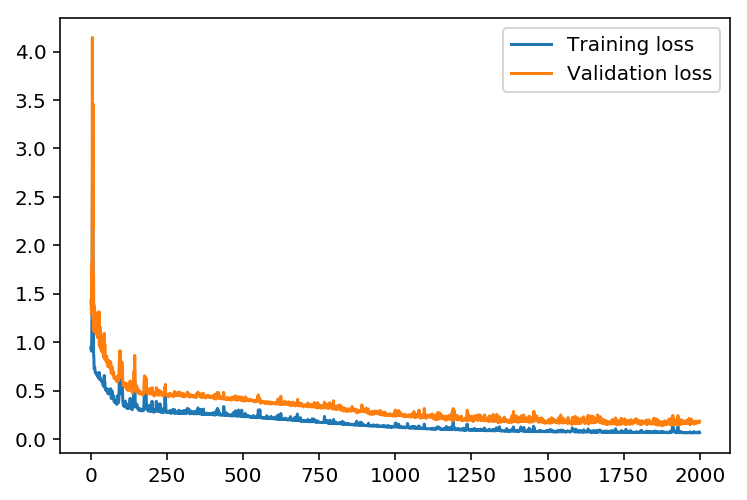

In [19]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()

Analizando la gráfica anterior, podemos ver que tanto la pérdida de entrenamiento como la de validación disminuyeron, por lo que el modelo no está sobreajustado, eso es una buena señal para tener buenas predicciones en los datos de prueba.

## Analizando predicciones <a id='predictions'></a>

Finalmente, usaremos los datos de prueba para ver qué tan bien nuestra red está modelando los datos.

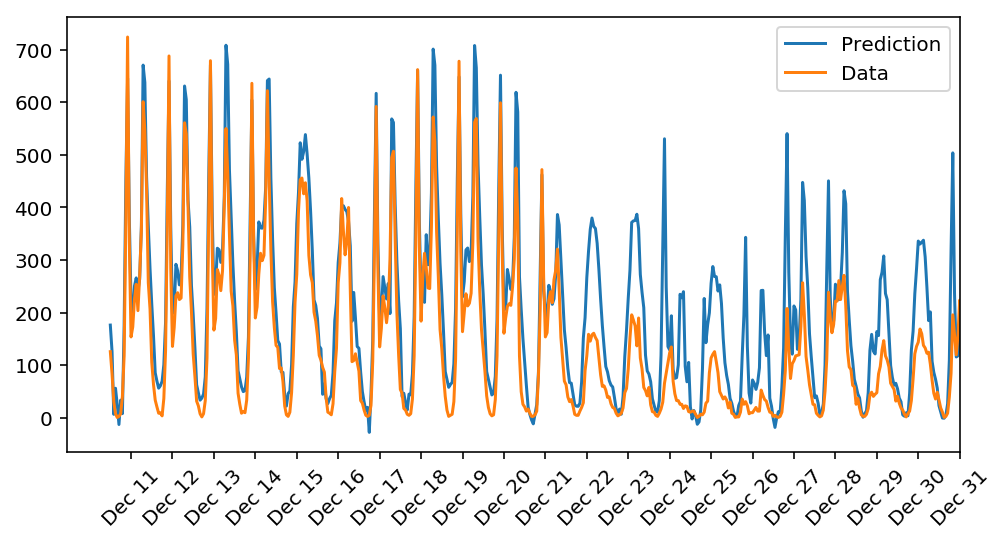

In [20]:
fig, ax = plt.subplots(figsize=(8,4))

# Realizar predicciones en los datos de prueba
mean, std = scaled_features['cnt']
predictions = network.run(test_features).T * std + mean

# Configurar gráfica
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt'] * std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

# Configurar las fechas a mostrar en la gráfica
dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

Podemos ver que el modelo funciona bien en los datos de prueba, sólo en los últimos días de diciembre hay un mal rendimiento. Una razón para eso es que tal vez el modelo necesita más datos para comprender los cambios en los últimos días del año.